In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
import pathlib, glob
from scipy.stats import norm
import time

In [3]:
import sys
sys.path.append('../src/')
from forward_modeling import project_volume, create_circular_mask, slice_volume, rotate_volume, take_slice, project_volume_bis, backprojection, add_slice
from scipy.interpolate import RegularGridInterpolator, griddata
from molecular_handling import particle
from molecular_handling import generate_dataset
from scipy.spatial.transform import Rotation as R
from forward_modeling import project_volume

In [4]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
output_dir = data_directory / 'test'
if output_dir.exists():
    print(f'Data directory {output_dir} exists: ')
    for x in list(output_dir.glob('*')):
        print(f'>>> {str(x)}') 

Data directory ../data/test exists: 
>>> ../data/test/particle_hires_xyz.npy
>>> ../data/test/particle_oddres_meta.npy
>>> ../data/test/particle_hires_map.npy
>>> ../data/test/.DS_Store
>>> ../data/test/particle_meta.npy
>>> ../data/test/het_particle_meta.npy
>>> ../data/test/particle_hires_data.npy
>>> ../data/test/particle_hires_meta.npy
>>> ../data/test/particle_map.npy
>>> ../data/test/particle_oddres_data.npy
>>> ../data/test/particle_xyz.npy
>>> ../data/test/particle_oddres_map.npy
>>> ../data/test/het_particle_data.npy
>>> ../data/test/particle_oddres_xyz.npy
>>> ../data/test/het_particle_map.npy
>>> ../data/test/particle_data.npy


## Evolution of the Mean-Squared Error with the length of the dataset

In [5]:
keyword='particle_oddres'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

lengths = [10,30,50,80,100,150,200,300,500,700,1000,1200,1500,2000,3000]
solutions = []
scores = []
mse = []

for length in lengths:
    volume_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(volume)))
    vol = (backprojection(dataset[:length], metadataset[:length,0:3]))
    vol_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(vol)))
    print(f"With length = {length}:")
    print(f"sum of pixels for backprojection: {np.sum(np.real(vol))}")
    print(f"sum of pixels for real volume: {np.sum(np.real(volume))}")
    print(f"sum of pixels for backprojection in Fourier space: {np.sum(np.abs(vol_fft))}")
    print(f"sum of pixels for real volume in Fourier space: {np.sum(np.abs(volume_fft))}")
    print(f"mse in real space: {(np.mean(np.power(volume-vol, 2)))}")

    print(50*"-")
    scores.append(np.sum(np.real(vol)))
    mse.append((np.mean(np.power(volume-vol, 2))))
    solutions.append(np.sum(np.real(volume)))

With length = 10:
sum of pixels for backprojection: 792.7008133117334
sum of pixels for real volume: 792.6914147189551
sum of pixels for backprojection in Fourier space: 52563.723175151674
sum of pixels for real volume in Fourier space: 58448.312608640634
mse in real space: 0.0033383101543929244
--------------------------------------------------
With length = 30:
sum of pixels for backprojection: 792.7007944946276
sum of pixels for real volume: 792.6914147189551
sum of pixels for backprojection in Fourier space: 52356.83008517097
sum of pixels for real volume in Fourier space: 58448.312608640634
mse in real space: 0.002049683911892744
--------------------------------------------------
With length = 50:
sum of pixels for backprojection: 792.70078984837
sum of pixels for real volume: 792.6914147189551
sum of pixels for backprojection in Fourier space: 50207.53103165138
sum of pixels for real volume in Fourier space: 58448.312608640634
mse in real space: 0.0019142866361428446
------------

In [6]:
keyword='particle'
dataset     = np.load(f'{output_dir}/{keyword}_data.npy')
metadataset = np.load(f'{output_dir}/{keyword}_meta.npy')
volume2      = np.load(f'{output_dir}/{keyword}_map.npy')
structure   = np.load(f'{output_dir}/{keyword}_xyz.npy')

lengths = [10,30,50,80,100,150,200,300,500,700,1000,1200,1500,2000,3000]
scores2 = []
mse2 = []
solutions2=[]

for length in lengths:
    volume_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(volume2)))
    vol2 = (backprojection(dataset[:length], metadataset[:length,0:3]))
    vol_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(vol2)))
    print(f"With length = {length}:")
    print(f"sum of pixels for backprojection: {np.sum(np.real(vol2))}")
    print(f"sum of pixels for real volume: {np.sum(np.real(volume2))}")
    print(f"sum of pixels for backprojection in Fourier space: {np.sum(np.abs(vol_fft))}")
    print(f"sum of pixels for real volume in Fourier space: {np.sum(np.abs(volume_fft))}")
    print(f"mse in real space: {(np.mean(np.power(volume2-vol2, 2)))}")

    print(50*"-")
    scores2.append(np.sum(np.real(vol2)))
    mse2.append(np.mean(np.power(volume2-vol2, 2)))
    solutions2.append(np.sum(np.real(volume2)))

With length = 10:
sum of pixels for backprojection: 562.3995199835698
sum of pixels for real volume: 720.6748632877983
sum of pixels for backprojection in Fourier space: 50423.36185306636
sum of pixels for real volume in Fourier space: 53294.07101520368
mse in real space: 0.001343599740656733
--------------------------------------------------
With length = 30:
sum of pixels for backprojection: 553.7443198240973
sum of pixels for real volume: 720.6748632877983
sum of pixels for backprojection in Fourier space: 50534.763743120704
sum of pixels for real volume in Fourier space: 53294.07101520368
mse in real space: 0.00105006051291434
--------------------------------------------------
With length = 50:
sum of pixels for backprojection: 558.9585294016373
sum of pixels for real volume: 720.6748632877983
sum of pixels for backprojection in Fourier space: 50345.41230664957
sum of pixels for real volume in Fourier space: 53294.07101520368
mse in real space: 0.0008954493905402923
---------------

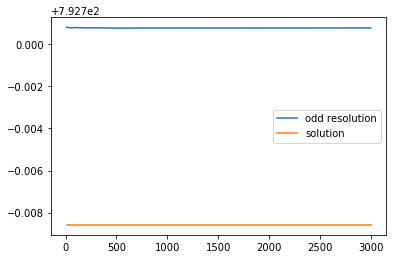

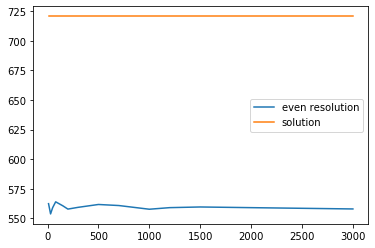

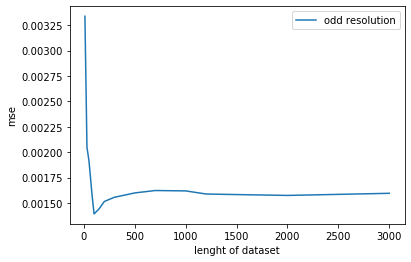

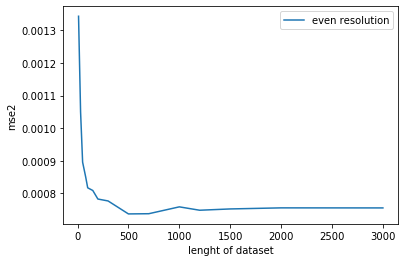

In [7]:
plt.plot(lengths, scores, label='odd resolution')
plt.plot(lengths,solutions, label='solution')
plt.legend()
plt.show()

plt.plot(lengths, scores2, label='even resolution')
plt.plot(lengths,solutions2, label='solution')
plt.legend()
plt.show()


plt.plot(lengths, mse, label='odd resolution')
plt.xlabel('lenght of dataset')
plt.ylabel('mse')
plt.legend()
plt.show()

plt.plot(lengths, mse2, label='even resolution')
plt.xlabel('lenght of dataset')
plt.ylabel('mse2')
plt.legend()
plt.show()

Comments:

- The reconstruction doesn't lose intensity when the number of voxels per dimension is odd
- However the mean squared error is higher in the case odd

## Evolution of the Mean-Squared Error with the size of the grid

In [8]:
crds = np.array([[0.,5.,5.],[5.,5.,5.],[5.,5.,0.]])
sizes_grid = [8,9,16,17,32,33,64,65,128,129,256,257]
scores_ = []
solutions = []
mse_ = []
for size_grid in sizes_grid:
    start = time.time()
    print(f"With res = {size_grid}x{size_grid}:")
    particle_ = particle(n_atom=3, rads_atom=[2.,2.,2.], crds = crds,size_grid=size_grid)
    particle_.create_map()
    volume = particle_.volume
    data, metadata = generate_dataset(particle_, n_projections=100, save=False)
    
    volume_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(volume)))
    vol = (backprojection(data, metadata[:,0:3]))
    vol_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(vol)))
    end = time.time()

    print(f"sum of pixels for backprojection: {np.sum(np.real(vol))}")
    print(f"sum of pixels for real volume: {np.sum(np.real(volume))}")
    print(f"sum of pixels for backprojection in Fourier space: {np.sum(np.abs(vol_fft))}")
    print(f"sum of pixels for real volume in Fourier space: {np.sum(np.abs(volume_fft))}")
    print(f"mse in real space: {(np.mean(np.power(volume-vol, 2)))}")
    print(f"time required: {end-start}")
    print(50*"-")
    
    scores_.append(np.sum(np.real(vol)))
    solutions.append(np.sum(np.real(volume)))
    mse_.append((np.mean(np.power(volume-vol, 2))))

With res = 8x8:
100 images were created
sum of pixels for backprojection: 5.810492413616709
sum of pixels for real volume: 8.287035136242396
sum of pixels for backprojection in Fourier space: 339.0426775305235
sum of pixels for real volume in Fourier space: 633.3305091026141
mse in real space: 0.003965477839027289
time required: 0.1652841567993164
--------------------------------------------------
With res = 9x9:
100 images were created
sum of pixels for backprojection: 12.386245529581892
sum of pixels for real volume: 12.383579015201255
sum of pixels for backprojection in Fourier space: 319.04098915466415
sum of pixels for real volume in Fourier space: 1026.558693052858
mse in real space: 0.005548796301406224
time required: 0.18987798690795898
--------------------------------------------------
With res = 16x16:
100 images were created
sum of pixels for backprojection: 58.696896350522096
sum of pixels for real volume: 81.64471878297617
sum of pixels for backprojection in Fourier space:

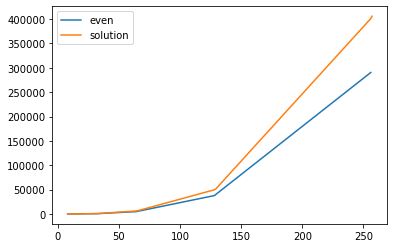

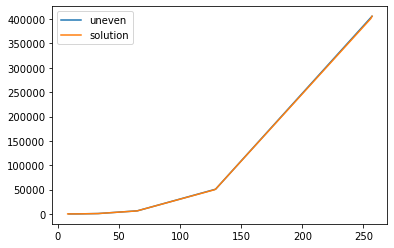

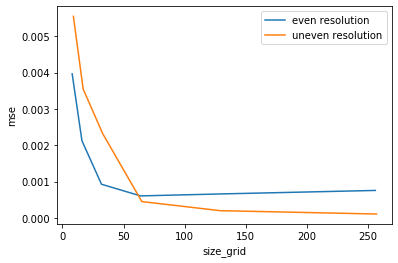

In [9]:
plt.plot([sizes_grid[2*i] for i in range(len(sizes_grid)//2)], [scores_[2*i] for i in range(len(scores_)//2)], label='even')
plt.plot(sizes_grid,solutions, label='solution')
plt.legend()
plt.show()

plt.plot([sizes_grid[2*i+1] for i in range(len(sizes_grid)//2)], [scores_[2*i+1] for i in range(len(scores_)//2)], label='uneven')
plt.plot(sizes_grid,solutions, label='solution')
plt.legend()
plt.show()

plt.plot([sizes_grid[2*i] for i in range(len(sizes_grid)//2)], [mse_[2*i] for i in range(len(mse_)//2)], label='even resolution')
plt.xlabel('size_grid')
plt.ylabel('mse')
plt.plot([sizes_grid[2*i+1] for i in range(len(sizes_grid)//2)], [mse_[2*i+1] for i in range(len(mse_)//2)], label='uneven resolution')
plt.legend()
plt.show()

#plt.plot(sizes_grid, [mse_[i]/sizes_grid[i]**3 for i in range(len(mse_))], label='mean squared error')
#plt.xlabel('size_grid')
#plt.ylabel('averaged mse')
#plt.legend()
#plt.show()